In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import torchvision
import torch.nn.functional as F
import numpy as np
from numpy import nan
from pandas import read_csv

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from datetime import datetime
import holidays

from sympy import init_printing, Matrix
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter

import os
import time
import sys
from tqdm import tqdm
#from tqdm.notebook import tqdm
import copy

Pour réaliser ce travail, nous avons travailler sur la partition Juliet pour faciliter l\'exécution du code comme on peut le voir ci-dessous.

In [2]:
%%bash
nvidia-smi

Wed Feb  5 19:09:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:07:00.0 Off |                    0 |
| N/A   35C    P0             66W /  400W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

On s'occupe dans un premier d'analyser le dataset, on consate alors qu'une grande partie des données sont manquantes, on remplace alors ces valeurs manquantes dans un premier temps par des null et on rajoute une colonne . Puis comme suggéré, pour le traitement de ces données, on rajoute le nombre de watt-heures restants qui peuvent être calculés à partir de l'énergie active en convertissant d'abord l'énergie active en wattheures, puis en soustrayant l'autre énergie active sous-comptée en watt-heures.

In [4]:
%%skip

# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'Datetime':[0,1]}, index_col=['Datetime'])
# summarize
print(dataset.shape)
print(dataset.head())
# mark all missing values
dataset.replace('?', nan, inplace=True)
# add a column for for the remainder of sub metering
values = dataset.values.astype('float32')
dataset['Sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

On sauvegarde l'ensemble des données au format .csv et on affiche les différentes colonnes.

/tmp/ipykernel_121839/3936465141.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

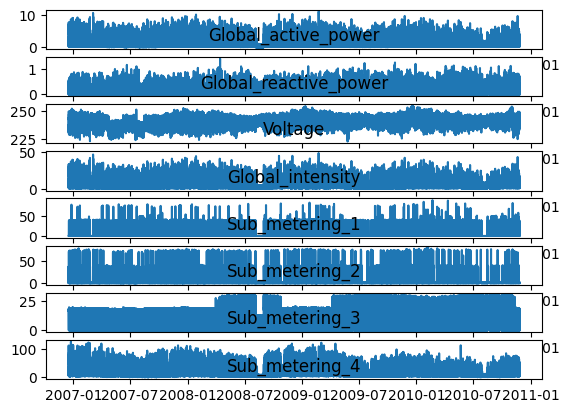

In [5]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
print(dataset.head())

plt.figure()
for i in range(len(dataset.columns)):
	plt.subplot(len(dataset.columns), 1, i+1)
	name = dataset.columns[i]
	plt.plot(dataset[name])
	plt.title(name, y=0)
plt.show()

Pour des besoins de simplification lors de l'entraînement, On utilise la méthode **resample().mean()** pour rééchantillonner les données par jour et calculer la moyenne quotidienne de chaque colonne de l'ensemble de données. on fait de même pour la colonne des heures. On sauvegardera de nouveau les nouvelles données toujours au format .csv. On affiche alors la nouvelle dustribution des données.

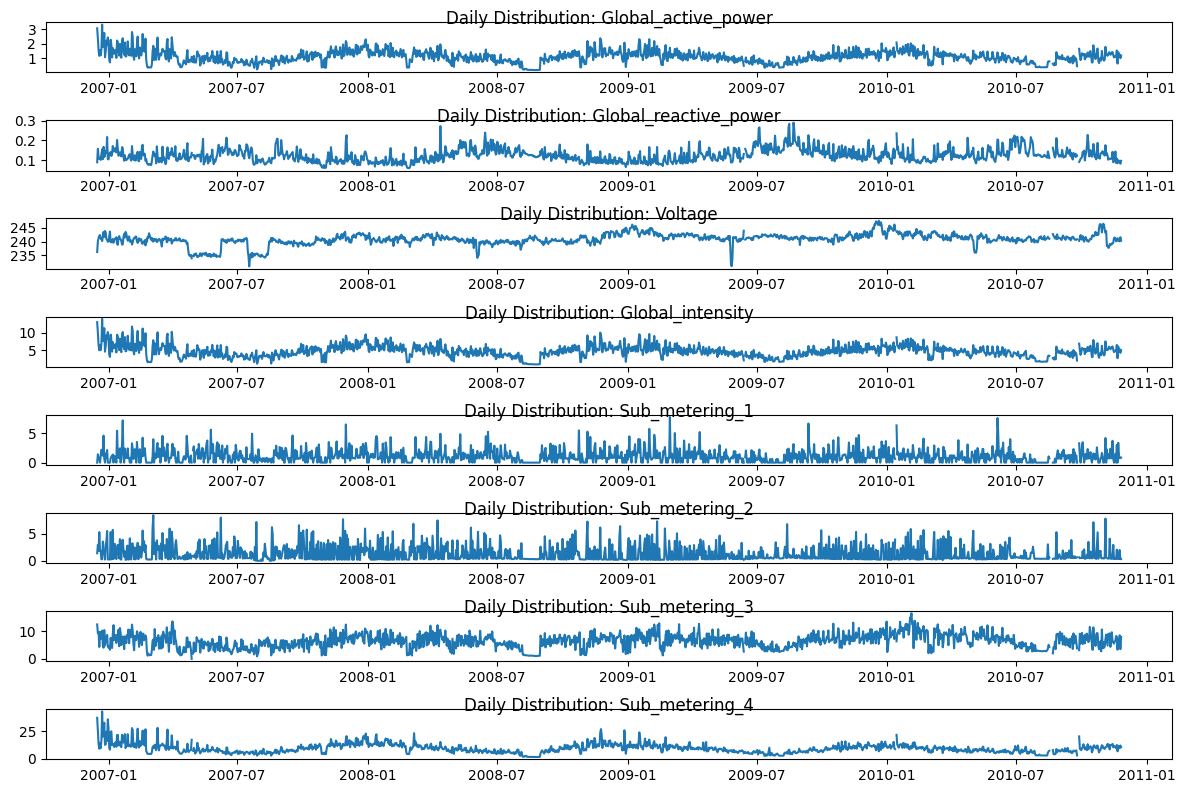

In [6]:
# Plot daily distribution
plt.figure(figsize=(12, 8))
daily_data = dataset.resample('D').mean()  # Resample by day and calculate the mean
for i in range(len(daily_data.columns)):
    plt.subplot(len(daily_data.columns), 1, i + 1)
    name = daily_data.columns[i]
    plt.plot(daily_data.index, daily_data[name])
    plt.title(f'Daily Distribution: {name}', y=0.8)
plt.tight_layout()
plt.show()

/tmp/ipykernel_121839/1394378584.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = dataset.resample('H').mean()  # Resample by hour and calculate the mean


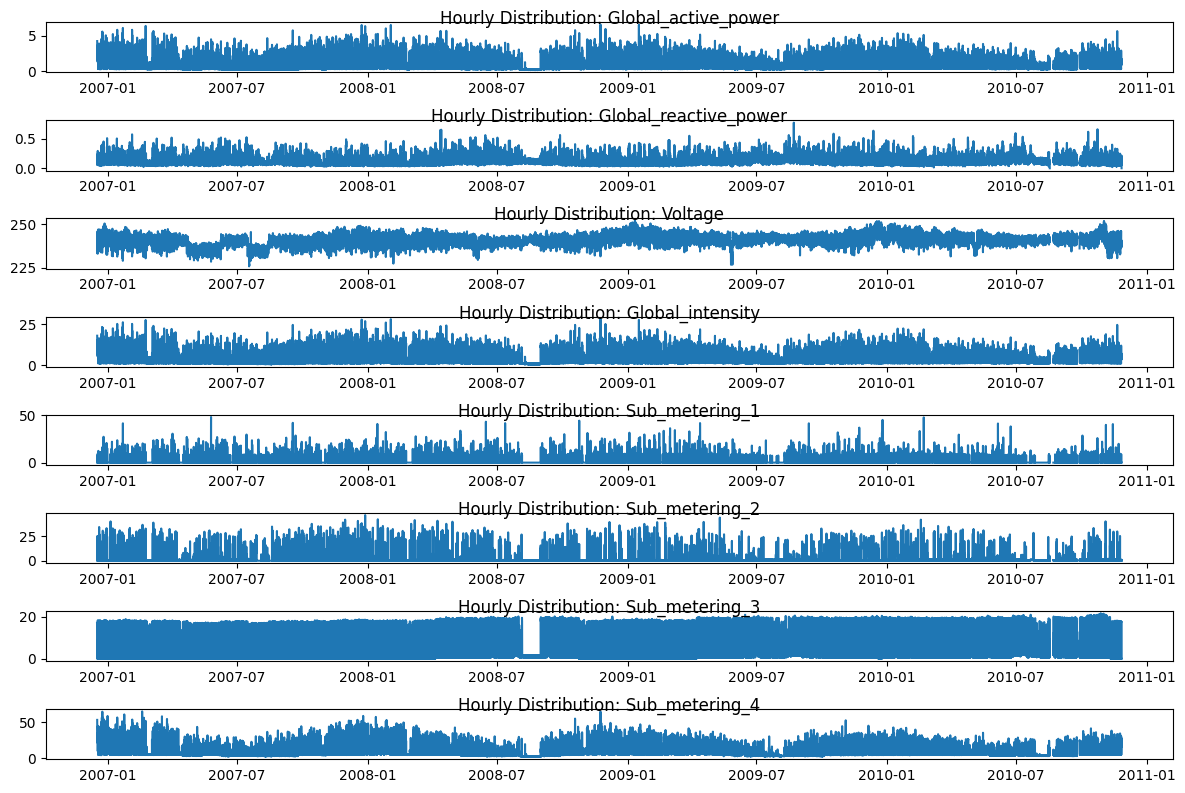

In [7]:
# Plot hourly distribution
plt.figure(figsize=(12, 8))
hourly_data = dataset.resample('H').mean()  # Resample by hour and calculate the mean
for i in range(len(hourly_data.columns)):
    plt.subplot(len(hourly_data.columns), 1, i + 1)
    name = hourly_data.columns[i]
    plt.plot(hourly_data.index, hourly_data[name])
    plt.title(f'Hourly Distribution: {name}', y=0.8)
plt.tight_layout()
plt.show()

/tmp/ipykernel_121839/3936465141.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

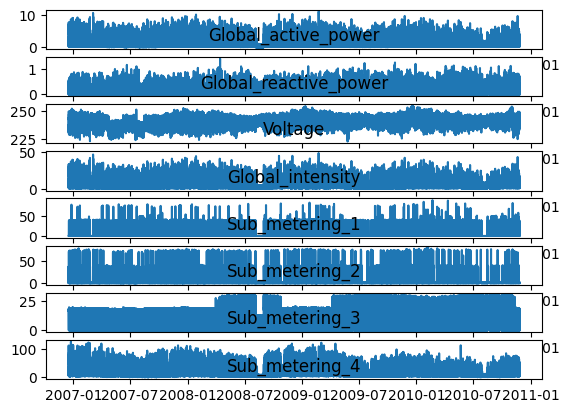

In [8]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
print(dataset.head())

plt.figure()
for i in range(len(dataset.columns)):
	plt.subplot(len(dataset.columns), 1, i+1)
	name = dataset.columns[i]
	plt.plot(dataset[name])
	plt.title(name, y=0)
plt.show()

On va réaliser une matrice de corrélation sur les données non échantillonés et sur les données échantillonnées, afin d'identifier les features les plus utiles.

/tmp/ipykernel_121839/1509532806.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


Matrix([
[  1.0,  0.247,   -0.4,  0.999,  0.484,  0.435,  0.639,  0.701],
[0.247,    1.0, -0.112,  0.266,  0.123,  0.139, 0.0896,  0.212],
[ -0.4, -0.112,    1.0, -0.411, -0.196, -0.167, -0.268, -0.271],
[0.999,  0.266, -0.411,    1.0,  0.489,   0.44,  0.627,  0.703],
[0.484,  0.123, -0.196,  0.489,    1.0, 0.0547,  0.103,  0.125],
[0.435,  0.139, -0.167,   0.44, 0.0547,    1.0, 0.0809, 0.0852],
[0.639, 0.0896, -0.268,  0.627,  0.103, 0.0809,    1.0,  0.179],
[0.701,  0.212, -0.271,  0.703,  0.125, 0.0852,  0.179,    1.0]])

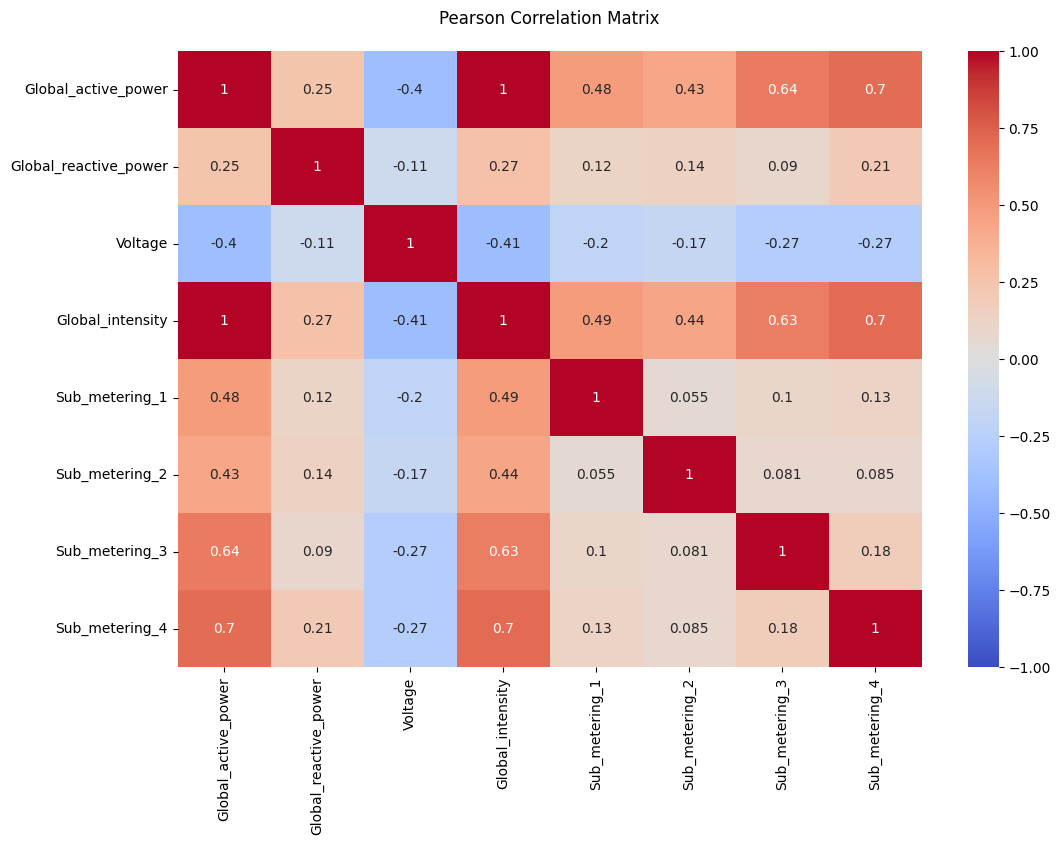

In [9]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
#print(dataset.columns)
#plot the pearson correlation matrix of the dataset which shows the correlation between the variables and labels them accordingly
correlation = dataset.corr()
#pretty print the correlation matrix here
display(Matrix(correlation).evalf(3))
# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix', pad=20)
plt.show()


/tmp/ipykernel_121839/1481767106.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  datasetm = dataset.resample('M').mean()
/tmp/ipykernel_121839/1481767106.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dataseth = dataset.resample('H').mean()


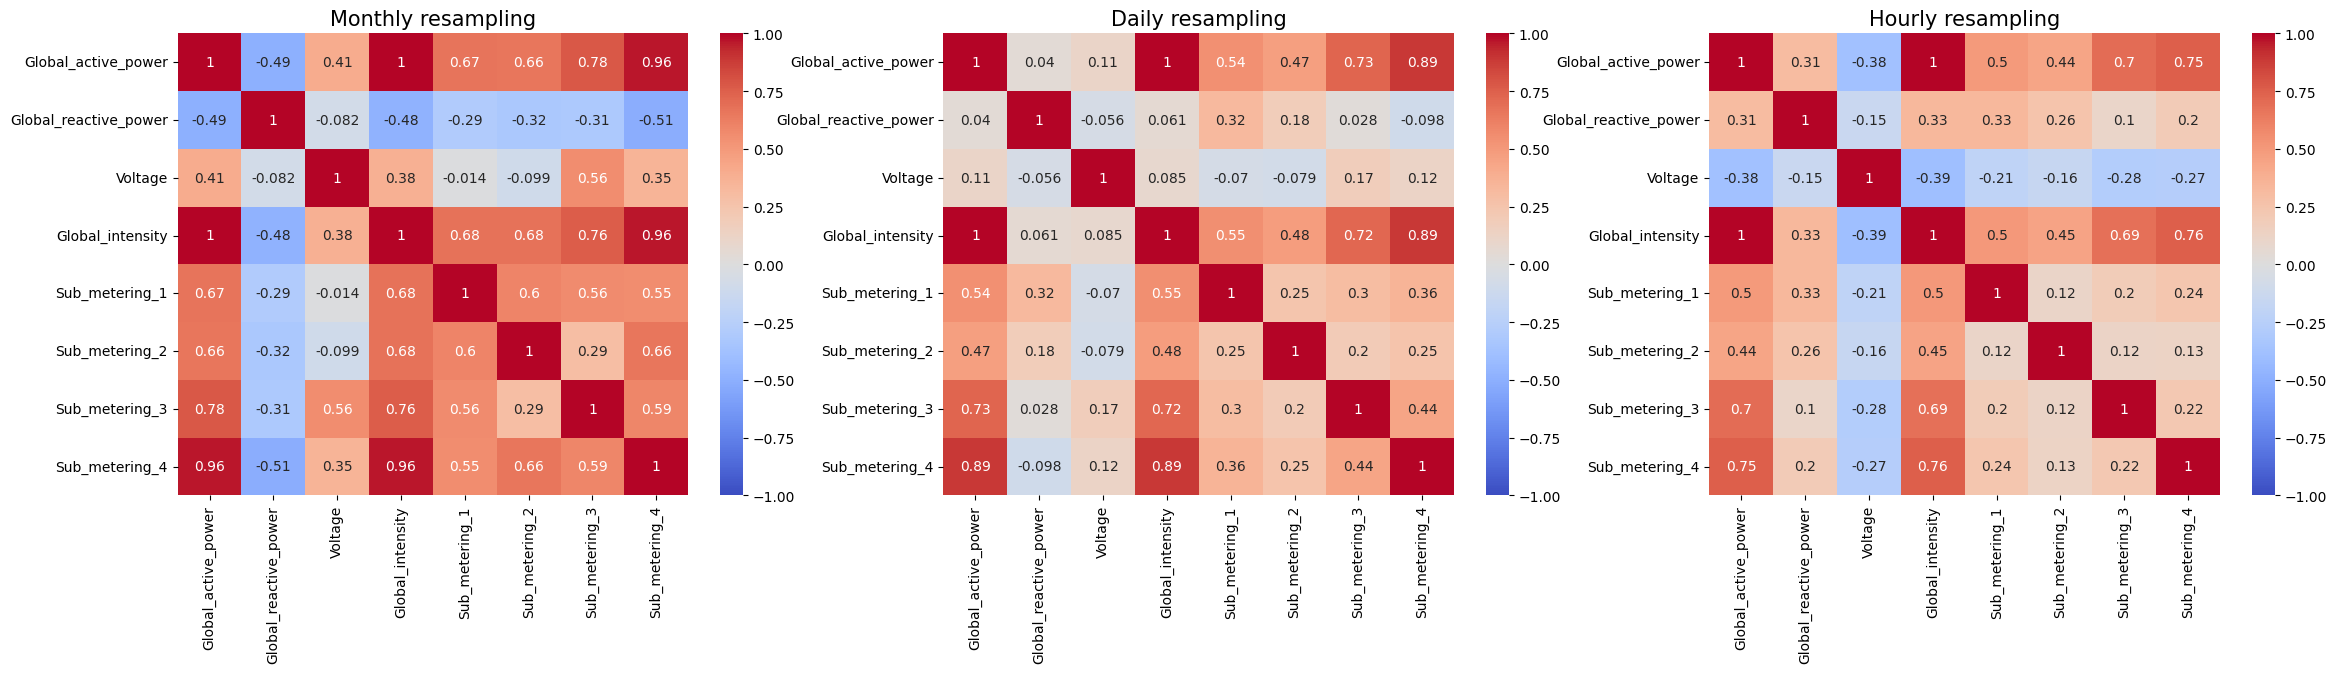

In [10]:
f= plt.figure(figsize=(28,6))

ax=f.add_subplot(131)
datasetm = dataset.resample('M').mean()
sns.heatmap(datasetm.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Monthly resampling', size=15)

ax=f.add_subplot(132)
datasetd = dataset.resample('D').mean()
sns.heatmap(datasetd.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Daily resampling', size=15)
  
ax=f.add_subplot(133)
dataseth = dataset.resample('H').mean()
sns.heatmap(dataseth.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Hourly resampling', size=15)
plt.show()

On constate alors ci-dessus que en fonction de la période de prédiction que l'on souhaite faire, toutes les features ne sont pas utiles. Comme pour le voltage qui n'est pas très intéressant pour la prédiction sur la consommation horaire, alors qu'elle l'est plus sur la consomamtion mensuelle.

Ci-dessous, on affiche le nombre de données manquantes par colonne, et on constate qu'il manque beaucoup de données.

In [11]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
#show number of missing values in each column
dataset.isnull().sum()

/tmp/ipykernel_121839/721238349.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Sub_metering_4           25979
dtype: int64

Si on affiche aussi la distribution de nos données, on consate que chaque feature ne suit pas la même distribution.

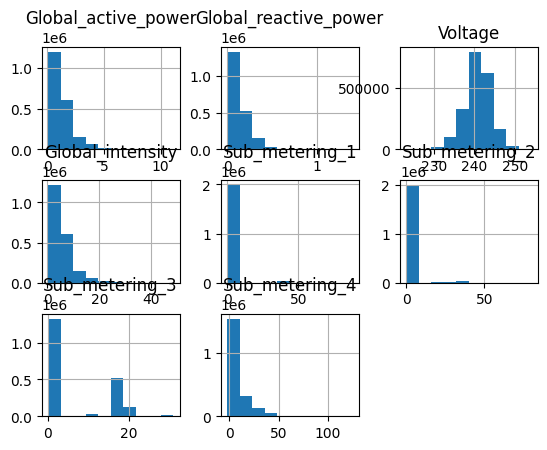

Since most of these distributions aren't normally distributed, we can't use the mean to fill in the missing values. We could use a median instead. Additionnally, normalization of the dataset can be done but standardization shoudl be avoided here as it will make the data more Gaussian-like and this is not the case for this dataset.


In [12]:
#show the distrbution of all values in the dataset
dataset.hist()
plt.show()
print("Since most of these distributions aren't normally distributed, we can't use the mean to fill in the missing values. We could use a median instead. Additionnally, normalization of the dataset can be done but standardization shoudl be avoided here as it will make the data more Gaussian-like and this is not the case for this dataset.")

Avec ce qui a été constaté au-dessus, on va réaliser diggérents traitements sur ce dataset. 

D'abord, on combine les colonnes Date et Time pour créer une nouvelle colonne Datetime au format datetime. Les colonnes originales Date et Time sont ensuite supprimées car parfois, on constatait que la conne Datetime ne se charger pas correctement avec l'utilisation de la fonction **read_csv()**.

Une nouvelle colonne Sub_metering_4 est ajoutée pour représenter la différence entre la puissance active globale et la somme des sous-comptages 1, 2 et 3.

Le code calcule les différences quotidiennes et annuelles de la puissance active globale et ajoute ces différences comme nouvelles colonnes. Ces colonnes sont également converties en type float.

On ordonne chronologiquement les données.

On calcule la consommation d'énergie à différentes échelles de temps : horaire, quotidienne et mensuelle et on crée également des colonnes cibles pour les prédictions futures, comme la consommation horaire du jour suivant, la consommation quotidienne de la semaine suivante, etc.

On décide de remplacer les valeurs manquantes qui sont imputées en utilisant la médiane

On ajoute de nouvelles caractéristiques basées sur le temps sont ajoutées un indicateur de week-end, un indicateur de jour férié, et la saison.

On sauvegarde dans un nouveau fichier CSV ces nouvelles modifications.

In [13]:
%%skip
print("In any case, we will either use MinMaxScaler or RobustScaler to normalize the data. We will also use the median to fill in the missing values udring imputation of the dataset.")
#for the time, we will make a dumb LSTM model with no data processing for now for comparaison purposes

#we will create a sanatized version of the dataset, seperate from the original one and compare the two

# Load dataset
df = pd.read_csv("household_power_consumption.txt", sep=';', header=0, low_memory=False)
print(df.columns)

# Combine Date and Time manually
df = df.assign(Datetime=pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", errors="coerce"))

# Drop original Date and Time columns (optional)
df.drop(columns=["Date", "Time"], inplace=True)

# Set index if needed
#df.set_index("Datetime", inplace=True)

print(df.head())

# Define numerical columns
numeric_cols = ["Global_active_power", "Global_reactive_power", "Voltage",
                "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

df.replace('?', nan, inplace=True)

for col in numeric_cols:
    df[col] = df[col].astype(float)

# Add a column for the remainder of sub metering
df['Sub_metering_4'] = (df["Global_active_power"] * 1000 / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

# Daily differencing
df["Global_active_power_daily_diff"] = df["Global_active_power"].diff(periods=24*60)

# Annual differencing
df["Global_active_power_annual_diff"] = df["Global_active_power"].diff(periods=24*60*365)

added_cols = ["Sub_metering_4", "Global_active_power_daily_diff", "Global_active_power_annual_diff"]

for col in added_cols:
    df[col] = df[col].astype(float)
    
# Ensure Datetime is sorted
df = df.sort_values("Datetime")

# Compute energy consumption at different time scales
df["Hourly_Consumption"] = df["Global_active_power"]
df["Daily_Consumption"] = df.groupby(df["Datetime"].dt.date)["Global_active_power"].transform("sum")
df["Monthly_Consumption"] = df.groupby(df["Datetime"].dt.to_period("M"))["Global_active_power"].transform("sum")

# Create target columns (future predictions), better to include them now for normalization and scaling later after splitting the data
df["Next_Day_Hourly_Consumption"] = df["Hourly_Consumption"].shift(-24)  # Next day's same hour
df["Next_Week_Daily_Consumption"] = df["Daily_Consumption"].shift(-7)    # Daily for next week
df["Next_Month_Daily_Consumption"] = df["Daily_Consumption"].shift(-30)  # Daily for next month
df["Next_Year_Monthly_Consumption"] = df["Monthly_Consumption"].shift(-365)  # Monthly for next year

# Impute missing values and create missing indicators
for col in numeric_cols + added_cols:
    df[f"{col}_was_missing"] = df[col].isna()  # Boolean flag for missing values
    #imputation should be done after splitting the data into training and testing sets
    #df.fillna({col: df[col].median()}, inplace=True)  # Median imputation

print(df.columns)

# Sort by datetime (in case it's unordered)
df.sort_values("Datetime", inplace=True)

# Create new time-based features
df["Hour"] = df["Datetime"].dt.hour
df["Weekday"] = df["Datetime"].dt.weekday  # 0=Monday, 6=Sunday
df["Is_Weekend"] = df["Weekday"] >= 5

# Add French holiday feature
fr_holidays = holidays.FR()
df["Is_Holiday"] = df["Datetime"].dt.date.astype(str).apply(lambda x: x in fr_holidays)

# add season feature
df["Season"] = df["Datetime"].dt.month.apply(lambda x: (x % 12 + 3) // 3)

#move datetime to front of the dataframe
cols = list(df)
cols.insert(0, cols.pop(cols.index('Datetime')))
df = df.loc[:, cols]

# Save the updated dataset
df.to_csv("household_power_consumption_processed_with_features.csv", index=False)

print("Dataset updated and saved as household_power_consumption_processed_with_features.csv")


On initialise 3 fonctions qui vont permettre de remplacer les données manquantes. On a mm_scaler qui est un MinMaxScaler qui normalise les données en les mettant à l'échelle entre 0 et 1. Puis r_scaler un RobustScaler qui normalise les données en utilisant les statistiques robustes (médiane et écart interquartile), et imputer qui est un SimpleImputer qui remplit les valeurs manquantes avec la médiane de chaque colonne.


Datetime                                            0
Global_active_power                             25979
Global_reactive_power                           25979
Voltage                                         25979
Global_intensity                                25979
Sub_metering_1                                  25979
Sub_metering_2                                  25979
Sub_metering_3                                  25979
Sub_metering_4                                  25979
Global_active_power_daily_diff                  37391
Global_active_power_annual_diff                555992
Hourly_Consumption                              25979
Daily_Consumption                                   0
Monthly_Consumption                                 0
Next_Day_Hourly_Consumption                     26003
Next_Week_Daily_Consumption                         7
Next_Month_Daily_Consumption                       30
Next_Year_Monthly_Consumption                     365
Global_active_power_was_miss

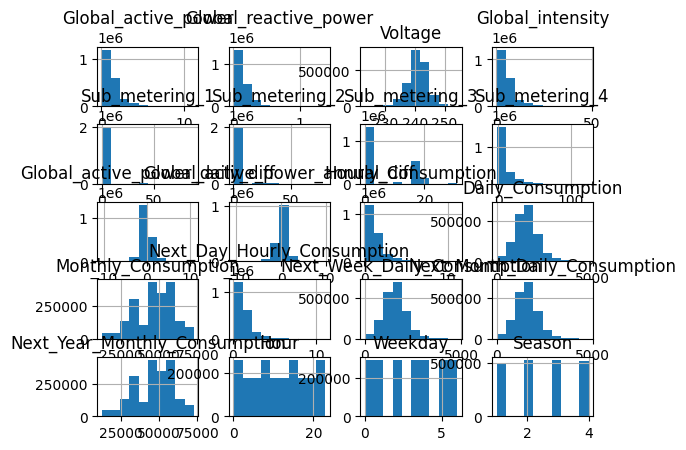

In [14]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption_processed_with_features.csv', header=0)
#show number of missing values in each column
print(dataset.isnull().sum())
mm_scaler = MinMaxScaler()
r_scaler = RobustScaler()
imputer = SimpleImputer(strategy='median')
# Apply winsorization (clipping the top and bottom 0.1%) which helps to reduce the effect of outliers, will be done after splitting and before the scaling
#lower_percentile = 0.1
#upper_percentile = 99.9
#
#for col in numeric_cols:
#    lower_limit = np.percentile(df[col], lower_percentile)
#    upper_limit = np.percentile(df[col], upper_percentile)
#    
#    # Clip values outside the 0.1% and 99.9% range
#    df[col] = np.clip(df[col], lower_limit, upper_limit)
dataset.hist()
plt.show()


On affiche une matrice de corrélations avec les nouvelles colonnes ajoutés où on constate la neutralité de ces nouvelles features par rapport aux autres.

/tmp/ipykernel_121839/1928150395.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_copy[timestamp] = pd.to_datetime(dataset_copy[timestamp])


Matrix([
[      1.0, -0.0418,  0.0535,   0.249,  -0.0458, -0.0144,    -0.038,  0.0543, -0.0924,  0.00142,   0.0166, -0.0418,    -0.126,     -0.15,   5.43e-5, -0.000405,  -0.00233,    0.0047,     0.218],
[  -0.0418,     1.0,   0.247,    -0.4,    0.999,   0.484,     0.435,   0.639,   0.701,     0.58,    0.557,     1.0,     0.392,     0.252,     0.282,    0.0658,    0.0846,   -0.0028,    -0.127],
[   0.0535,   0.247,     1.0,  -0.112,    0.266,   0.123,     0.139,  0.0896,   0.212,    0.182,    0.192,   0.247,    0.0112,    -0.104,     0.128,    0.0695,    0.0889,   0.00809,    0.0585],
[    0.249,    -0.4,  -0.112,     1.0,   -0.411,  -0.196,    -0.167,  -0.268,  -0.271,    -0.21,   -0.221,    -0.4,    0.0752,      0.19,    -0.176,   -0.0214,   -0.0217,    0.0137,    -0.154],
[  -0.0458,   0.999,   0.266,  -0.411,      1.0,   0.489,      0.44,   0.627,   0.703,    0.581,    0.558,   0.999,     0.386,     0.242,     0.282,    0.0672,    0.0865,  -0.00281,    -0.121],
[  -0.0144,   0.484, 

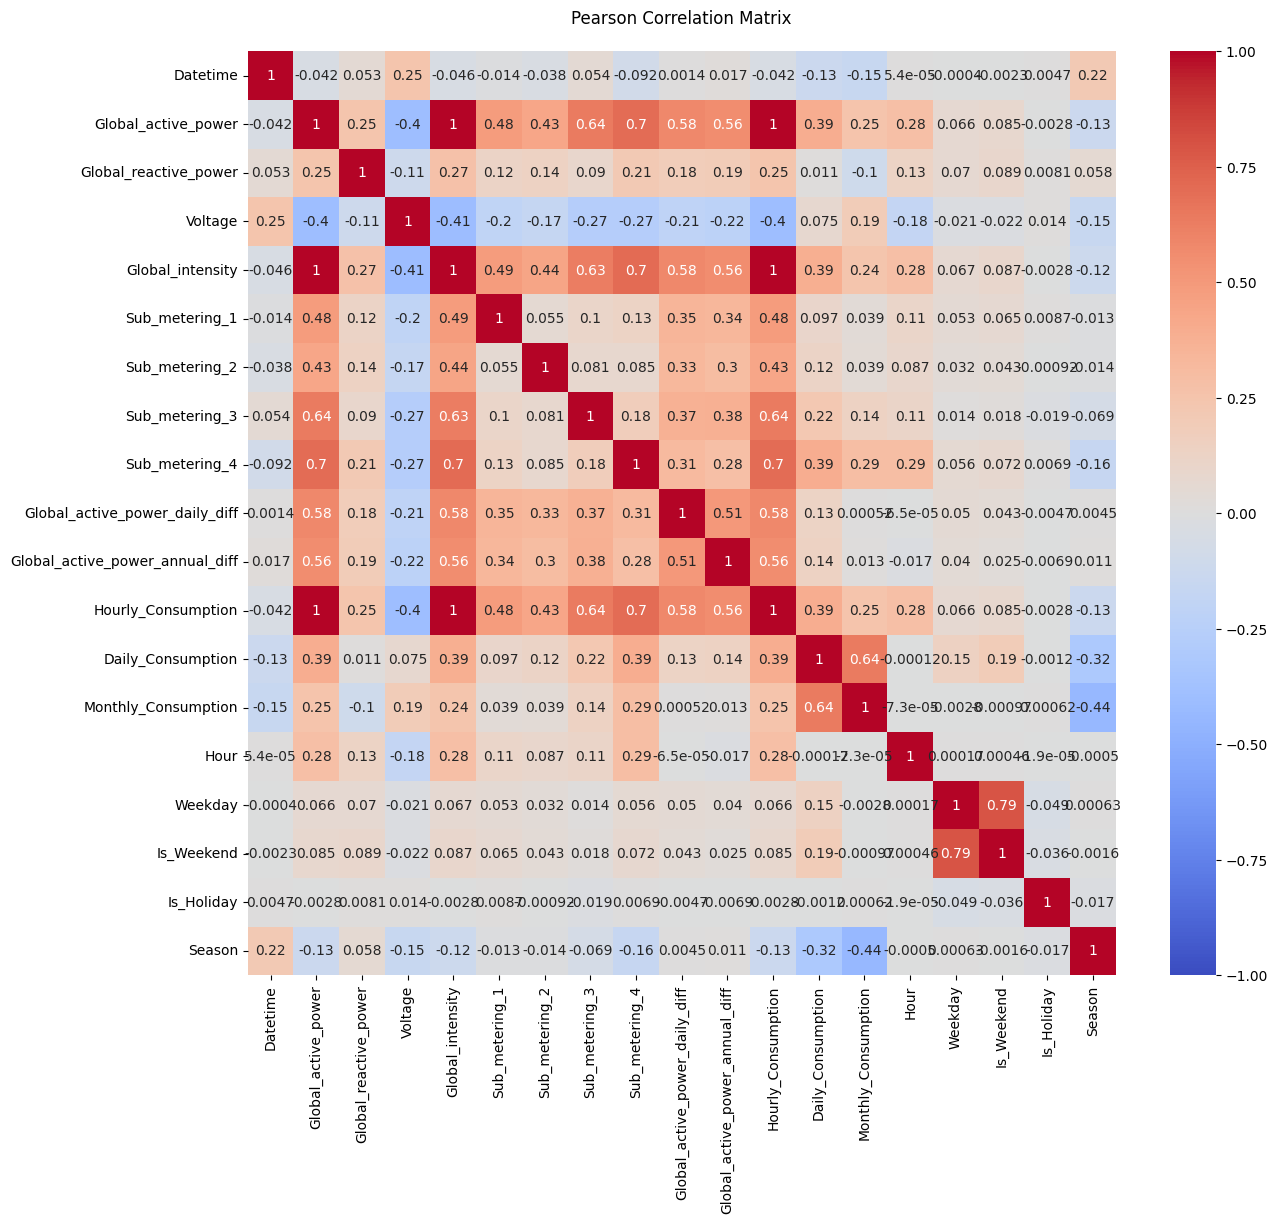

/tmp/ipykernel_121839/1928150395.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  datasetm = dataset_copy.resample('M', on=timestamp).mean()
/tmp/ipykernel_121839/1928150395.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dataseth = dataset_copy.resample('H', on=timestamp).mean()


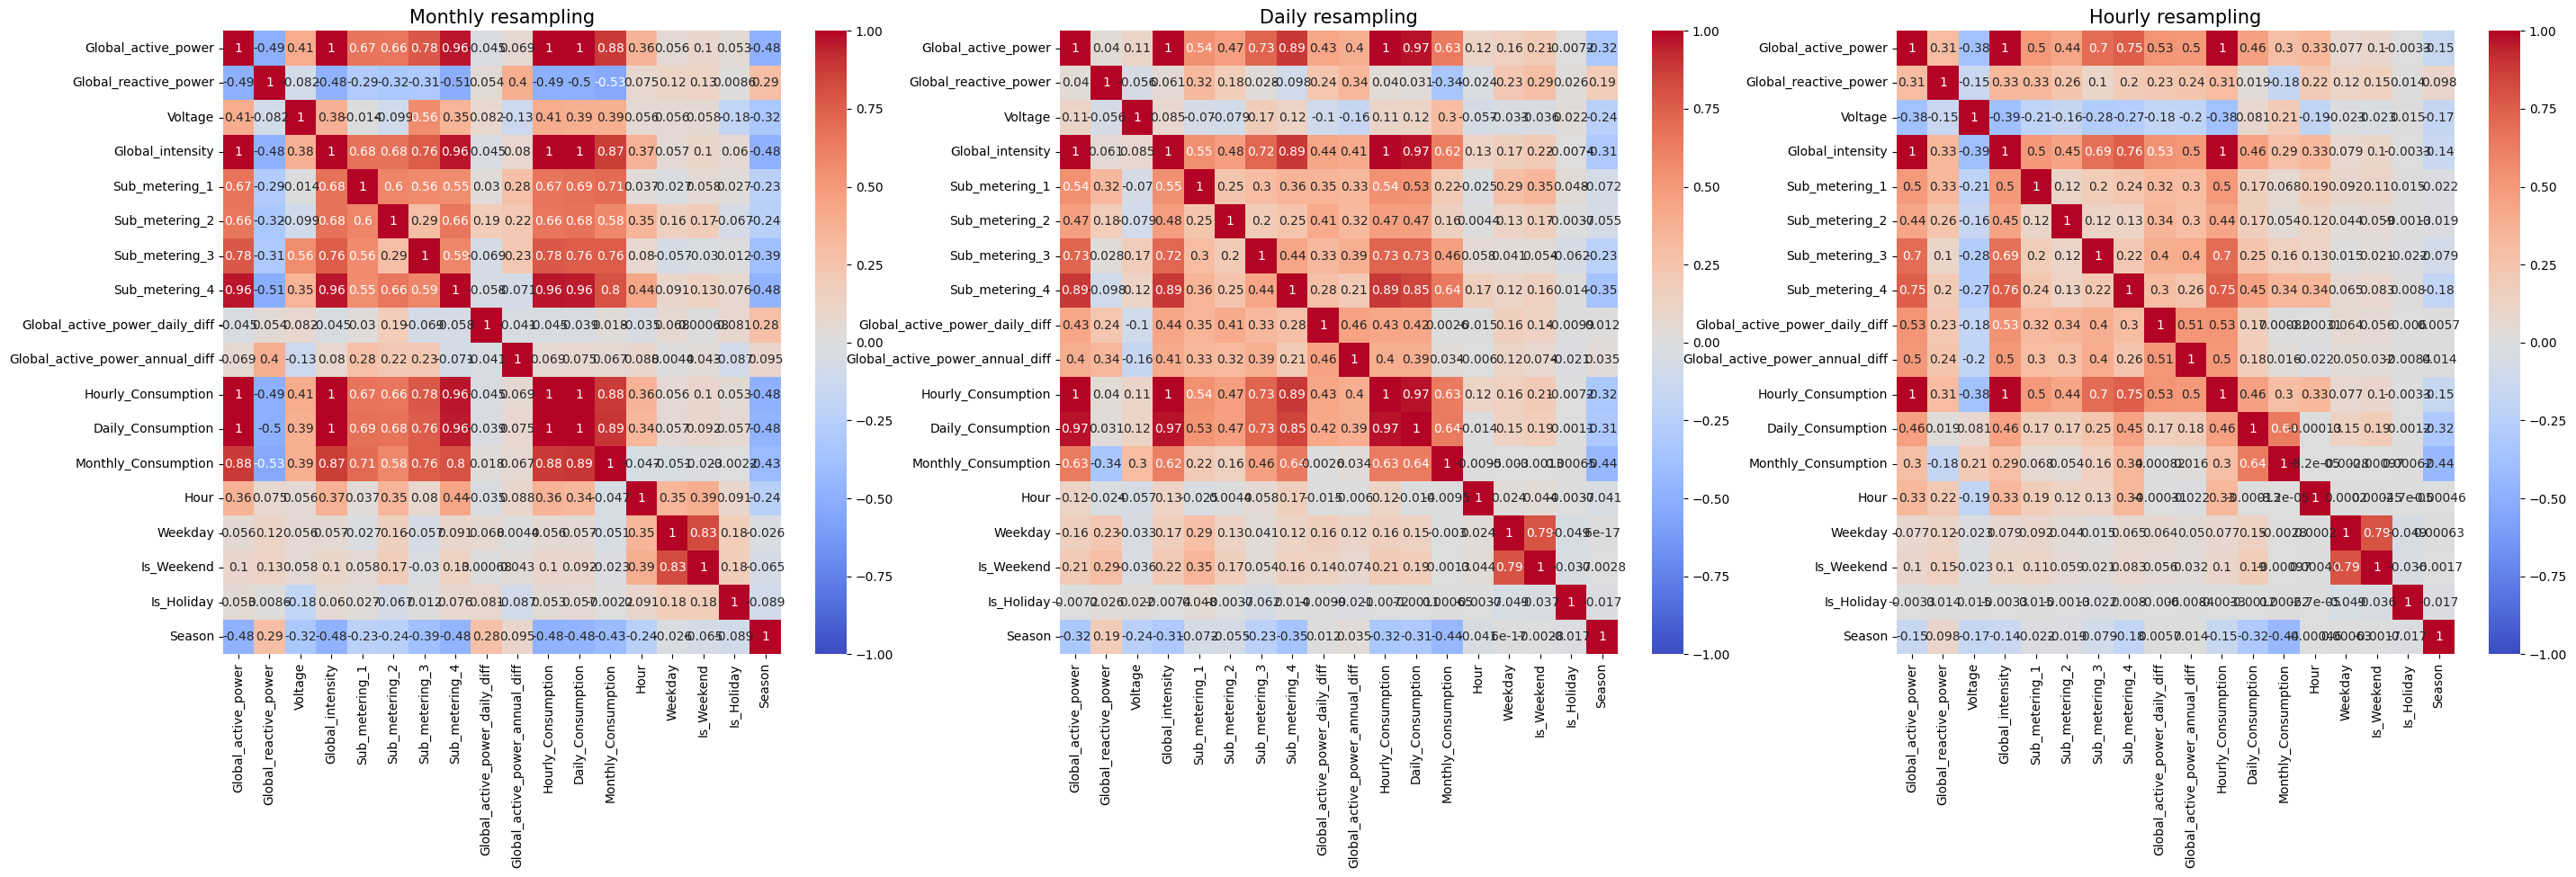

In [15]:
features = ["Next_Day_Hourly_Consumption", "Next_Week_Daily_Consumption",
                          "Next_Month_Daily_Consumption", "Next_Year_Monthly_Consumption"]
timestamp = "Datetime"
dataset_copy = dataset.loc[:, ~dataset.columns.str.contains("was_missing")]
dataset_copy[timestamp] = pd.to_datetime(dataset_copy[timestamp])
dataset_copy = dataset_copy.drop(columns=features)
correlation = dataset_copy.corr()
#pretty print the correlation matrix here
display(Matrix(correlation).evalf(3))

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix', pad=20)
plt.show()
f= plt.figure(figsize=(34,9))

ax=f.add_subplot(131)
datasetm = dataset_copy.resample('M', on=timestamp).mean()

sns.heatmap(datasetm.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Monthly resampling', size=15)

ax=f.add_subplot(132)
datasetd = dataset_copy.resample('D', on=timestamp).mean()
sns.heatmap(datasetd.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Daily resampling', size=15)
  
ax=f.add_subplot(133)
dataseth = dataset_copy.resample('H', on=timestamp).mean()
sns.heatmap(dataseth.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Hourly resampling', size=15)
plt.show()

On génère des séquences d'entrée X et des valeurs cibles y pour l'entraînement du modèle de LSTM .

In [16]:
def create_sequences(data, target_col, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback, :-1].values)  # All selected features
        y.append(data.iloc[i+lookback, target_col])  # Target value
    return np.array(X), np.array(y)

On crée une fonction ci-dessous qui sélectionne les meileurs features à sélectionner pour réaliser l'entraînement.

In [17]:
def select_features(X, y, num_features=10):
    """
    Selects the top 'num_features' best features using SelectKBest.
    """
    selector = SelectKBest(score_func=f_regression, k=num_features)
    X_selected = selector.fit_transform(X, y)

    # Get selected feature names
    selected_features = X.columns[selector.get_support()]
    
    return selected_features

 On définit des classes d'architectures de réseaux de neurones pour traiter des séquences temporelles. LSTM2 et GRU2 sont des modèles récurrents simples qui utilisent chacun uen couche LSTM ou GRU combiné à une couche linéaire, tandis que CNN_LSTM2 combine des couches convolutives pour l'extraction de caractéristiques spatiales avec un LSTM pour capturer les dépendances temporelles.

In [18]:
class LSTM2(nn.Module):
    def __init__(self, hidden_size, in_size, num_layers=1, out_size=1):
        super(LSTM2, self).__init__()
        self.lstm = nn.LSTM(input_size=in_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)  # Adjusted for single output

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1, :]  # Correct indexing
        out = self.fc(last_hidden_states)
        return out, h

class GRU2(nn.Module):
    def __init__(self, hidden_size, in_size, num_layers=1, out_size=1):
        super(GRU2, self).__init__()
        self.gru = nn.GRU(input_size=in_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)  # Adjusted for single output

    def forward(self, x, h=None):
        out, h = self.gru(x, h)
        last_hidden_states = out[:, -1, :]  # Get last time step's hidden state
        out = self.fc(last_hidden_states)
        return out, h

class CNN_LSTM2(nn.Module):
    def __init__(self, in_channels, seq_len, num_features, hidden_size, num_lstm_layers=1, out_size=1):
        super(CNN_LSTM2, self).__init__()

        # CNN Feature Extraction
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate CNN output size after convolutions & pooling
        cnn_output_size = (seq_len // 2) * 32  # After pooling once (assuming stride=2)

        # LSTM
        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size,
                            num_layers=num_lstm_layers, batch_first=True)

        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        # CNN Part (Expecting shape: [batch, seq_len, num_features])
        x = x.permute(0, 2, 1)  # Reshape to [batch, num_features, seq_len] for 1D CNN
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))

        # Reshape for LSTM: [batch, seq_len/2, num_features*channels]
        x = x.reshape(x.shape[0], -1, x.shape[1] * x.shape[2])

        # LSTM Part
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last timestep output

        return out

On définit une fonction train_lstm_model qui entraîne un modèle LSTM  sur un ensemble de données, évalue ses performances sur des ensembles de validation et de test, et renvoie le meilleur modèle trouvé ainsi que l'historique des pertes d'entraînement et de validation. Voici une explication détaillée de ce que fait chaque partie du code :

La fonction train_lstm_model prend en entrée plusieurs paramètres, notamment le modèle à entraîner, les chargeurs de données pour les ensembles d'entraînement, de validation et de test, un objet de mise à l'échelle pour inverser la transformation des données, un optimiseur, une fonction de perte, et divers autres paramètres comme le nombre d'époques et le dispositif d'entraînement (CPU ou GPU).

Après l'entraînement, le meilleur modèle est évalué sur l'ensemble de test. Les prédictions et les valeurs réelles sont collectées et transformées à l'échelle originale à l'aide de l'objet de mise à l'échelle. Les prédictions et les valeurs réelles sont ensuite tracées pour visualiser les performances du modèle sur l'ensemble de test. Enfin, les courbes de perte d'entraînement et de validation sont tracées pour montrer l'évolution des pertes au fil des époques. La fonction renvoie le meilleur modèle trouvé, ainsi que les historiques des pertes d'entraînement et de validation.

In [37]:

def train_lstm_model(model, train_loader, val_loader, test_loader, scaler, optimizer, loss_fn, features, epochs=100, device="cpu", scaling=True, is_lstm=True):
    """
    Trains an LSTM model and evaluates it on validation and test sets using DataLoader.
    
    Parameters:
        model (torch.nn.Module): LSTM model
        train_loader (torch.utils.data.DataLoader): DataLoader for training data
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data
        test_loader (torch.utils.data.DataLoader): DataLoader for test data
        scaler (sklearn.preprocessing.StandardScaler): Scaler for inverse transform
        optimizer (torch.optim.Optimizer): Optimizer for training
        loss_fn (callable): Loss function
        epochs (int): Number of training epochs (default=100)
        device (str): Device to train on ('cpu' or 'cuda')

    Returns:
        best_model (torch.nn.Module): The best trained model
        training_loss (list): Training loss history
        validation_loss (list): Validation loss history
    """

    model.to(device)
    
    best_model = None
    min_val_loss = sys.maxsize

    training_loss = []
    validation_loss = []
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/LSTM_trainer_{}'.format(timestamp))

    log_freq=20
    num_batches = len(train_loader)
    log_interval = max(1, num_batches // log_freq)
    
    for epoch in range(epochs+1):
        model.train(True)
        epoch_train_loss = 0.0
        running_loss = 0.0
        i = 0
        
        # Training loop over batches
        for x_batch, y_batch in tqdm(train_loader, desc="Epoch Progress", unit="batch", leave=False, total=len(train_loader)):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            y_pred, _ = model(x_batch)
            
            loss = loss_fn(y_pred, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            running_loss += loss.item()

            if i % log_interval == (log_interval - 1):
                last_loss = running_loss / log_interval
                tb_x = epoch * num_batches + i + 1
                writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.0
            i += 1

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        training_loss.append(epoch_train_loss)

        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in tqdm(val_loader, desc="Validation Progress", unit="batch", leave=False, total=len(val_loader)):
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                
                y_pred, _ = model(x_val_batch)
                
                val_loss = loss_fn(y_pred, y_val_batch)
                epoch_val_loss += val_loss.item()

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader)
        validation_loss.append(epoch_val_loss)

        # Save the best model based on validation loss
        if epoch_val_loss < min_val_loss:
            best_model = copy.deepcopy(model)
            min_val_loss = epoch_val_loss

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f'Epoch {epoch}: Train Loss = {round(epoch_train_loss, 4)}, '
                      f'Val Loss = {round(epoch_val_loss, 4)}')

    # Evaluation on test set
    best_model.eval()
    predicted = []
    real = []
    
    with torch.no_grad():
        for x_test_batch, y_test_batch in tqdm(test_loader, desc="Test Progress", unit="batch", total=len(test_loader)):
            x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)

            if is_lstm:
                _, h_list = model(x_test_batch)
                h = tuple([h[-1].unsqueeze(0).to(device) for h in h_list])  # Ensure correct shape
            else:
                _, h_list = model(x_test_batch)
                h = h_list.unsqueeze(0).to(device) if h_list.dim() == 2 else h_list.to(device)

            y_pred, _ = model(x_test_batch, h)

            predicted.extend(y_pred.cpu().numpy())
            real.extend(y_test_batch.cpu().numpy())

    print(len(test_loader))

    print(len(predicted), len(real))
    
    predicted = np.array(predicted).reshape(-1, 1)
    real = np.array(real).reshape(-1, 1)

    print(predicted.shape, real.shape)

    # Convert back to original scale (if needed)
    predicted = scaler.inverse_transform(np.hstack([np.zeros((predicted.shape[0], len(features))), predicted]))[:, -1]
    real = scaler.inverse_transform(np.hstack([np.zeros((real.shape[0], len(features))), real]))[:, -1]

    print(predicted.shape, real.shape)

    # Plot test predictions
    plt.figure(figsize=(10, 4))
    plt.title("Test Dataset Predictions")
    plt.plot(real, label='Real', color='green')  # Keep real values solid
    plt.plot(predicted, label='Predicted', linestyle='--', alpha=0.6, color='red')  # Dashed + see-through
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.title('Training Loss Curve')
    plt.yscale('log')
    plt.plot(training_loss, label='Training')
    plt.plot(validation_loss, label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return best_model, training_loss, validation_loss

On fais une fonction **save_model()** permettant de sauvegarder le modèle.

In [20]:
def save_model(model, architecture_name, target_name, directory="models/"):
    """
    Saves a trained PyTorch model with a filename based on its architecture and target variable.
    """

    os.makedirs(directory, exist_ok=True)

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    model_filename = f"{directory}{architecture_name}_{target_name}_{timestamp}.pth"

    # saves the model
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")

    return model_filename


On définti une fonction permettant de charger les différentes données sous la forme de tenseurs.

In [21]:
def load_torch_dataset(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64, num_workers=0):
    # Convert to PyTorch tensors
    X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Ensure correct shape
    
    X_val_torch = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_torch = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
    
    X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Create DataLoader
    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, num_workers=num_workers, shuffle=False)
    val_loader = DataLoader(TensorDataset(X_val_torch, y_val_torch), batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, val_loader, test_loader

On définit la fonction calculate_metrics qui évalue un modèle sur un ensemble de données en calculant trois métriques de performance : l'erreur quadratique moyenne (MSE), l'erreur absolue moyenne (MAE) et la racine de l'erreur quadratique moyenne (RMSE). Elle commence par déplacer le modèle vers le dispositif spécifié (CPU ou GPU) et le met en mode évaluation. Ensuite, elle parcourt les lots de données fournis par un data_loader, génère des prédictions avec le modèle, et calcule les erreurs MSE et MAE pour chaque lot. Ces erreurs sont accumulées et moyennées sur l'ensemble des échantillons pour obtenir les valeurs finales de MSE, MAE et RMSE, qui sont ensuite retournées.

In [22]:
def calculate_metrics(model, data_loader, device):
    model.to(device)
    
    model.eval()  # Set the model to evaluation mode
    total_mse = 0
    total_mae = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)

            # Calculate MSE and MAE
            mse = torch.mean((outputs - labels) ** 2)
            mae = torch.mean(torch.abs(outputs - labels))

            total_mse += mse.item() * inputs.size(0)
            total_mae += mae.item() * inputs.size(0)
            total_samples += inputs.size(0)

    # Average over all samples
    mse = total_mse / total_samples
    mae = total_mae / total_samples
    rmse = torch.sqrt(torch.tensor(mse)).item()  # Calculate RMSE

    return mse, mae, rmse

On définit un optimiseur ici Adam pour l'entraînement.

In [23]:
def get_optimizer(model, learning_rate, regularization=0):
    return torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)

In [24]:
%reload_ext tensorboard
logs_base_dir = "./runs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [25]:
import torch

torch.cuda.empty_cache()  # Releases unused memory
torch.cuda.reset_peak_memory_stats()  # Resets memory tracking

On réalise l'entraînement avec différents paramètres et différents modèles qui ont été dédinis précedemment.

Using device: cuda:1
Columns with all NaN values: []
Datetime                                            0
Global_active_power                             25979
Global_reactive_power                           25979
Voltage                                         25979
Global_intensity                                25979
Sub_metering_1                                  25979
Sub_metering_2                                  25979
Sub_metering_3                                  25979
Sub_metering_4                                  25979
Global_active_power_daily_diff                  37391
Global_active_power_annual_diff                555992
Hourly_Consumption                              25979
Daily_Consumption                                   0
Monthly_Consumption                                 0
Global_active_power_was_missing                     0
Global_reactive_power_was_missing                   0
Voltage_was_missing                                 0
Global_intensity_was_missing 

Epoch 1/60
Epoch 0: Train Loss = 0.0108, Val Loss = 0.0079


Epoch 11/60
Epoch 10: Train Loss = 0.006, Val Loss = 0.0067


Epoch 21/60
Epoch 20: Train Loss = 0.0055, Val Loss = 0.0059


Epoch 31/60
Epoch 30: Train Loss = 0.0054, Val Loss = 0.0057


Epoch 41/60
Epoch 40: Train Loss = 0.0053, Val Loss = 0.0058


Epoch 51/60
Epoch 50: Train Loss = 0.0053, Val Loss = 0.0056


Epoch 61/60
Epoch 60: Train Loss = 0.0052, Val Loss = 0.0056


Test Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1101.70batch/s]


61
3872 3872
(3872, 1) (3872, 1)
(3872,) (3872,)


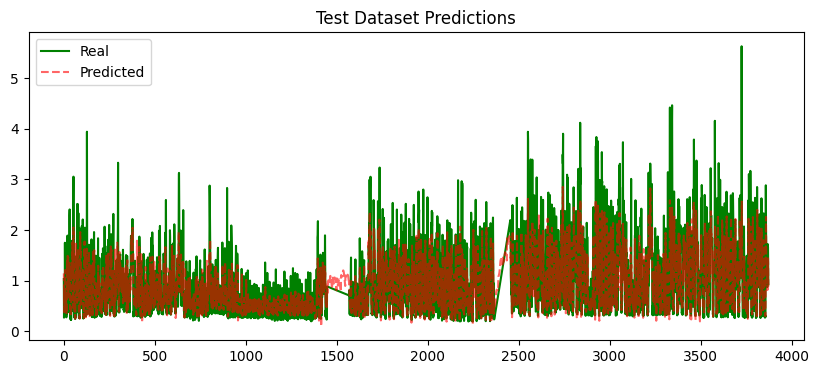

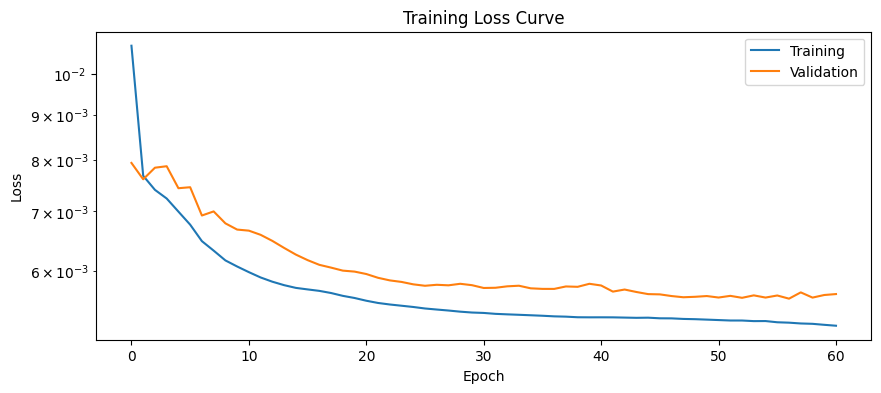

MSE: 0.0046, MAE: 0.0492, RMSE: 0.0680
Model saved as models/lstm_hourly_consumption_prediction_20250205-200034.pth


Epoch 1/60
Epoch 0: Train Loss = 0.0089, Val Loss = 0.0077


Epoch 11/60
Epoch 10: Train Loss = 0.0066, Val Loss = 0.0069


Epoch 21/60
Epoch 20: Train Loss = 0.0059, Val Loss = 0.0061


Epoch 31/60
Epoch 30: Train Loss = 0.0057, Val Loss = 0.0059


Epoch 41/60
Epoch 40: Train Loss = 0.0055, Val Loss = 0.0058


Epoch 51/60
Epoch 50: Train Loss = 0.0054, Val Loss = 0.0057


Epoch 61/60
Epoch 60: Train Loss = 0.0054, Val Loss = 0.0056


Test Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1187.43batch/s]


61
3872 3872
(3872, 1) (3872, 1)
(3872,) (3872,)


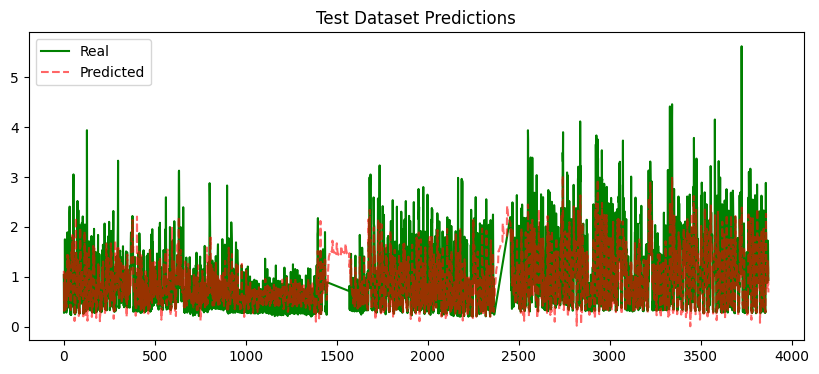

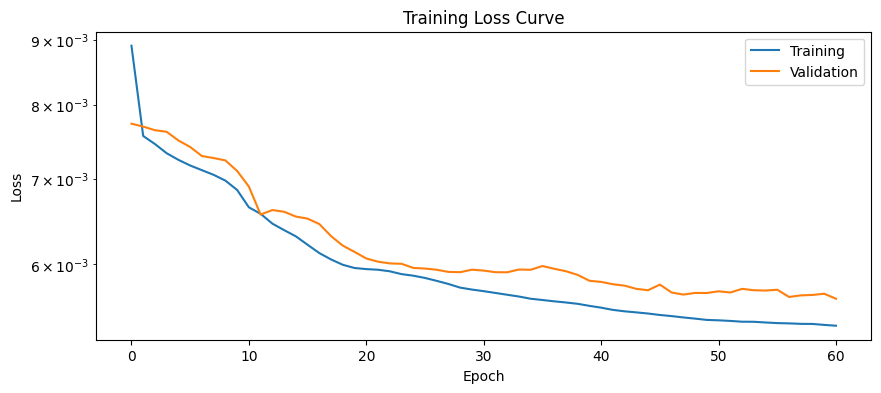

MSE: 0.0056, MAE: 0.0539, RMSE: 0.0751
Model saved as models/gru_hourly_consumption_prediction_20250205-200104.pth
Datetime                                            0
Global_active_power                             25979
Global_reactive_power                           25979
Voltage                                         25979
Global_intensity                                25979
Sub_metering_1                                  25979
Sub_metering_2                                  25979
Sub_metering_3                                  25979
Sub_metering_4                                  25979
Global_active_power_daily_diff                  37391
Global_active_power_annual_diff                555992
Hourly_Consumption                              25979
Daily_Consumption                                   0
Monthly_Consumption                                 0
Global_active_power_was_missing                     0
Global_reactive_power_was_missing                   0
Voltage_was_missing  

Epoch 1/60
Epoch 0: Train Loss = 0.0109, Val Loss = 0.0076


Epoch 11/60
Epoch 10: Train Loss = 0.0063, Val Loss = 0.0071


Epoch 21/60
Epoch 20: Train Loss = 0.0058, Val Loss = 0.0064


Epoch 31/60
Epoch 30: Train Loss = 0.0056, Val Loss = 0.0063


Epoch 41/60
Epoch 40: Train Loss = 0.0054, Val Loss = 0.0058


Epoch 51/60
Epoch 50: Train Loss = 0.0053, Val Loss = 0.006


Epoch 61/60
Epoch 60: Train Loss = 0.0052, Val Loss = 0.0058


Test Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 603.92batch/s]


61
3850 3850
(3850, 1) (3850, 1)
(3850,) (3850,)


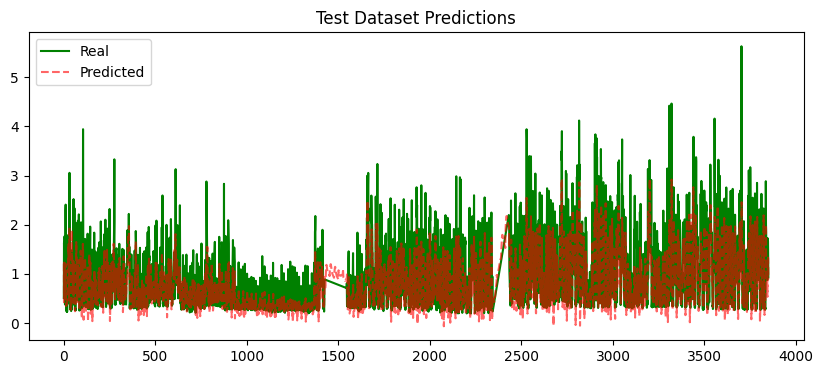

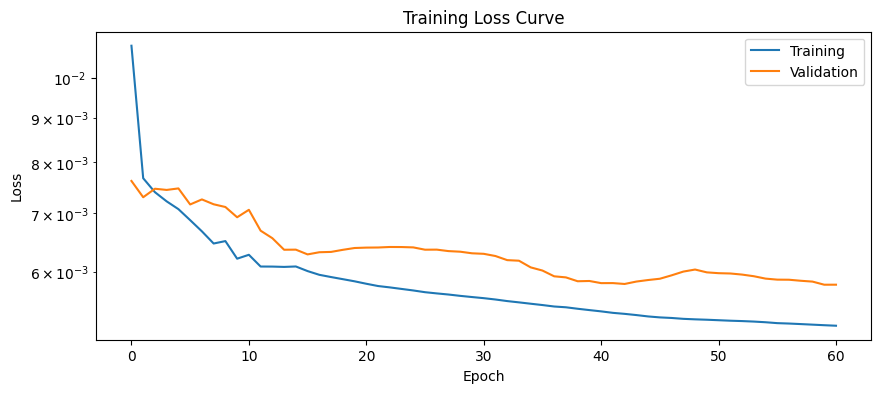

MSE: 0.0053, MAE: 0.0495, RMSE: 0.0730
Model saved as models/lstm_weekly_consumption_prediction_20250205-200146.pth


Epoch 1/60
Epoch 0: Train Loss = 0.0099, Val Loss = 0.0076


Epoch 11/60
Epoch 10: Train Loss = 0.0069, Val Loss = 0.007


Epoch 21/60
Epoch 20: Train Loss = 0.0061, Val Loss = 0.0061


Epoch 31/60
Epoch 30: Train Loss = 0.0057, Val Loss = 0.0057


Epoch 41/60
Epoch 40: Train Loss = 0.0055, Val Loss = 0.0056


KeyboardInterrupt: 

In [39]:
#train_lstm_model
#save_model
#calculate_metrics

###################################
#configuration pytorch settings
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

###################################

dataset = read_csv('household_power_consumption_processed_with_features.csv', header=0)

missing_cols = dataset.columns[dataset.isna().all()]
print("Columns with all NaN values:", missing_cols.tolist())

features = ["Next_Day_Hourly_Consumption", "Next_Week_Daily_Consumption",
            "Next_Month_Daily_Consumption", "Next_Year_Monthly_Consumption"] # features to drop

dataset = dataset.drop(columns=features)

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
# rest is TEST_RATIO

# Size of LSTM hidden state
LSTM_HIDDEN_SIZE = 128

LSTM_NUM_LAYERS = 1

# Size of GRU hidden state
GRU_HIDDEN_SIZE = 128

GRU_NUM_LAYERS = 1

# Size of CNN LSTM hidden state
CNN_LSTM_HIDDEN_SIZE = 50

# Optimizer learning rate
LEARNING_RATE = 0.002

TRAINING_EPOCHS = 60

#BATCH_SIZE = 64

#default is 0
L2_REGULARIZATION = 1e-5
#L2_REGULARIZATION = 0

NUM_AUTO_FEATURES = 10

LOSS = torch.nn.MSELoss()

DATASET_RATIO = len(dataset)

###################################
########### TEST PARAMETERS FOR LATER
sliding_window_range_size = {
    "hourly": [12, 24],
    "weekly": [7, 30],
    "monthly": [30, 90],
    "yearly": [12, 36]
}

sliding_window_size_minute = {
    "hourly": 60,
    "weekly": 60*24*7,
    "monthly": 60*24*30,
    "yearly": 60*24*365
}

batch_sizes_minute = {
    "hourly": 256,
    "weekly": 256,
    "monthly": 256,
    "yearly": 256
}

sliding_window_size_hour = {
    "hourly": 24,
    "weekly": 24*7,
    "monthly": 24*30,
    "yearly": 24*365
}

batch_sizes_hour = {
    "hourly": 64,
    "weekly": 64,
    "monthly": 64,
    "yearly": 64
}

###################################

sampling_periods = {
    "hourly": "h",
    "weekly": "D",
    "monthly": "D",
    "yearly": "M"
}

sliding_window_size = {
    "hourly": 24,
    "weekly": 7,
    "monthly": 30,
    "yearly": 12
}

batch_sizes = {
    "hourly": 64,
    "weekly": 32,
    "monthly": 16,
    "yearly": 4
}

model_name = "lstm"
timestamp = "Datetime"
target = "Global_active_power"

#na_columns = ["Global_active_power_daily_diff", "Global_active_power_annual_diff"]
dropped_columns = []

manually_selected_features = ["Season", "Is_Holiday", "Is_Weekend"]
#manually_selected_features = []

FIXED_SAMPLING = False
FIXED_SAMPLING_VALUE = "h" #"min"

for period_key, period_value in sampling_periods.items():
    
    df = dataset.head(DATASET_RATIO)
    
    df = df.drop(columns=dropped_columns) #drop problematic columns
    
    df[timestamp] = pd.to_datetime(df[timestamp])

    if FIXED_SAMPLING:
        df = df.resample(FIXED_SAMPLING_VALUE, on=timestamp).mean()
        if FIXED_SAMPLING_VALUE is "h":
            batch_size = batch_sizes_hour[period_key]
            window_size = sliding_window_size_hour[period_key]
        else:
            batch_size = batch_sizes_minute[period_key]
            window_size = sliding_window_size_minute[period_key]
    else:
        df = df.resample(period_value, on=timestamp).mean()   # Moyennes horaires
        batch_sizes[period_key]
        window_size = sliding_window_size[period_key]

    print(f"Training for {period_key} (sampling for {window_size} - {"FIXED SAMPLING" if FIXED_SAMPLING else "auto"})")

    print(df.isna().sum(), df.shape) 
    df = df.interpolate()
    df.dropna(inplace=True)
    print(df.isna().sum(), df.shape) 
 
    selected_features = select_features(df.drop(columns=[target]), df[target], NUM_AUTO_FEATURES).tolist()
    selected_features = list(set(selected_features + manually_selected_features))
    print(selected_features)
    #selected_features = ['Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    input_size = len(selected_features)  # Number of selected input features
    
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[selected_features + [target]])  # Include target
    df_scaled = pd.DataFrame(df_scaled, columns=selected_features + [target])
    
    #lookback = 24  # Example: use past 24 hours
    target_col = df_scaled.columns.get_loc(target)  # Target index
    
    X, y = create_sequences(df_scaled, target_col, lookback=window_size)
    
    train_size = int(len(X) * TRAIN_RATIO)
    val_size = int(len(X) * VAL_RATIO)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
    
    print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
    
    train_loader, val_loader, test_loader = load_torch_dataset(X_train, y_train, 
                                                               X_val, y_val, 
                                                               X_test, y_test, 
                                                               batch_size=batch_size)
    models = {
        "lstm": LSTM2(LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS, in_size=input_size).to(device),
        "gru": GRU2(GRU_HIDDEN_SIZE, num_layers=GRU_NUM_LAYERS, in_size=input_size).to(device)
    }

    for model_name, model_value in models.items():
    
        model = model_value
    
        opt = get_optimizer(model, LEARNING_RATE, L2_REGULARIZATION)
    
        best_model, train_loss, val_loss = train_lstm_model(model, train_loader, val_loader, test_loader, 
                                                            scaler, opt, LOSS, features=selected_features, 
                                                            epochs=TRAINING_EPOCHS, device=device, is_lstm=model_name is "lstm")
    
        mse, mae, rmse = calculate_metrics(best_model, test_loader, device)
        print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
        save_model(best_model, model_name + f"_{period_key}", "consumption_prediction")

Ci-dessus, on affiche les différentes prédictions réalisés par chaque modèle, où on constate que le modèle LSTM obtient ici la meilleur prédiction par rapport à GRU ou CNN_LSTM.

In [ ]:
#criterion = nn.MSELoss()  # Since we are predicting a continuous value
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#
#num_epochs = 20
#
#for epoch in range(num_epochs):
#    model.train()
#    total_train_loss = 0
#
#    for X_batch, y_batch in train_loader:
#        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#        optimizer.zero_grad()
#        y_pred, _ = model(X_batch)  # Forward pass
#        loss = criterion(y_pred, y_batch)  # Compute loss
#        loss.backward()  # Backpropagation
#        optimizer.step()  # Update weights
#        total_train_loss += loss.item()
#
#    # Validation phase
#    model.eval()
#    total_val_loss = 0
#    with torch.no_grad():
#        for X_batch, y_batch in val_loader:
#            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#            y_pred, _ = model(X_batch)
#            val_loss = criterion(y_pred, y_batch)
#            total_val_loss += val_loss.item()
#
#    print(f"Epoch {epoch+1}: Train Loss: {total_train_loss/len(train_loader):.4f}, Validation Loss: {total_val_loss/len(val_loader):.4f}")
#
#model.eval()
#test_preds, test_actuals = [], []
#
#with torch.no_grad():
#    for X_batch, y_batch in test_loader:
#        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#        preds, _ = model(X_batch)
#        test_preds.extend(preds.cpu().numpy())
#        test_actuals.extend(y_batch.cpu().numpy())
#
## Convert to NumPy
#test_preds = np.array(test_preds).reshape(-1, 1)
#test_actuals = np.array(test_actuals).reshape(-1, 1)
#
## Convert back to original scale (if needed)
#test_preds = scaler.inverse_transform(np.hstack([np.zeros((test_preds.shape[0], len(selected_features))), test_preds]))[:, -1]
#test_actuals = scaler.inverse_transform(np.hstack([np.zeros((test_actuals.shape[0], len(selected_features))), test_actuals]))[:, -1]
#
## Plot Predictions vs Actual
#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 5))
#plt.plot(test_actuals[:100], label="Actual", linestyle="dashed")
#plt.plot(test_preds[:100], label="Predicted")
#plt.legend()
#plt.title("LSTM Predictions vs Actual Values")
#plt.show()